In [ ]:
# https://medium.com/analytics-vidhya/eye-aspect-ratio-ear-and-drowsiness-detector-using-dlib-a0b2c292d706

In [ ]:
# EAR을 이용한 졸음운전탐지
# ; EAR - Eye Aspect Ratio

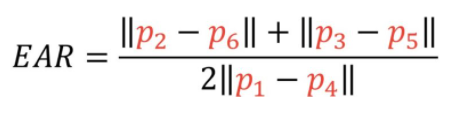

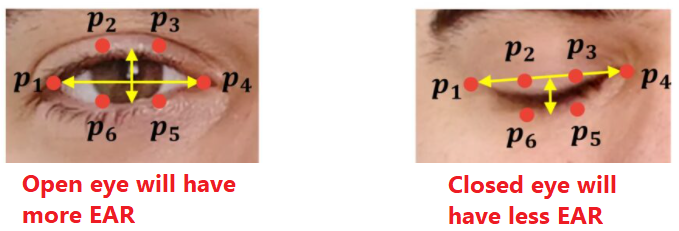

하나의 눈에 대한 EAR 계산 함수

In [ ]:
from scipy.spatial import distance as dist

def eye_aspect_ratio(eye):
    p2_minus_p6 = dist.euclidean(eye[1], eye[5])  
    p3_minus_p5 = dist.euclidean(eye[2], eye[4])
    p1_minus_p4 = dist.euclidean(eye[0], eye[3])
    ear = (p2_minus_p6 + p3_minus_p5) / (2.0 * p1_minus_p4)
    return ear

-----------------------------------------------------------

메인 코드

In [ ]:
# 라이브러리

import cv2
import dlib
import imutils
from imutils import face_utils

In [ ]:
# 전역변수 선언

FACIAL_LANDMARK_PREDICTOR = "shape_predictor_68_face_landmarks.dat"  # dlib의 사전 훈련된 얼굴 랜드마크 예측의 경로
MINIMUM_EAR = 0.2  # 임계값
MAXIMUM_FRAME_COUNT = 10 # 최대 프레임 수 ; 10프레임 이상 눈을 감고 있으면 졸음으로 감지

In [ ]:
# 인스턴스화(?) ; 클래스 내의 객체에 대해 특정한 변형을 정의하고 이름을 붙인 다음 인스턴스 생성

faceDetector = dlib.get_frontal_face_detector  # 이미지에서 얼굴 감지
landmarkFinder = dlib.shape_predictor(FACIAL_LANDMARK_PREDICTOR)  # 얼굴에서 68개의 포인트 감지
webcamFeed = cv2.VideoCapture(0)

In [ ]:
# 양쪽 눈에 대한 랜드마크 ID 시작과 끝 점 찾기

(leftEyeStart, leftEyeEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
(rightEyeStart, rightEyeEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]

In [ ]:
EYE_CLOSED_COUNTER = 0
try:
    while True:
        (status, image) = webcamFeed.read()
        image = imutils.resize(image, width=800)
        grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        faces = faceDetector(grayImage, 0)

        for face in faces:
            faceLandmarks = landmarkFinder(grayImage, face)
            faceLandmarks = face_utils.shape_to_np(faceLandmarks)

            leftEye = faceLandmarks[leftEyeStart:leftEyeEnd]
            rightEye = faceLandmarks[rightEyeStart:rightEyeEnd]

            leftEAR = eye_aspect_ratio(leftEye)
            rightEAR = eye_aspect_ratio(rightEye)

            ear = (leftEAR + rightEAR) / 2.0

            leftEyeHull = cv2.convexHull(leftEye)
            rightEyeHull = cv2.convexHull(rightEye)

            cv2.drawContours(image, [leftEyeHull], -1, (255, 0, 0), 2)
            cv2.drawContours(image, [rightEyeHull], -1, (255, 0, 0), 2)

            if ear < MINIMUM_EAR:
                EYE_CLOSED_COUNTER += 1
            else:
                EYE_CLOSED_COUNTER = 0

            cv2.putText(image, "EAR: {}".format(round(ear, 1)), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

            if EYE_CLOSED_COUNTER >= MAXIMUM_FRAME_COUNT:
                cv2.putText(image, "Drowsiness", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

        cv2.imshow("Frame", image)
        cv2.waitKey(1)
except:
    pass